### Importing Libraries

In [1]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install json-tricks
!pip install tensorflow
!pip install scikit-learn
!pip install keras
!pip install librosa
!pip install seaborn

In [2]:
%%capture
import numpy as np
import pandas as pd
import os
from json_tricks import dump, load

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

import time


from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

2024-08-24 15:27:35.141209: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-24 15:27:35.145630: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-24 15:27:35.158842: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-24 15:27:35.179434: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-24 15:27:35.185619: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-24 15:27:35.202447: I tensorflow/core/platform/cpu_feature_gu

In [3]:
# Emotion kind validation function for TESS database, due to emotions written within the file names.
def find_emotion_T(name):
        if('neutral' in name): return "01"
        elif('happy' in name): return "03"
        elif('sad' in name): return "04"
        elif('angry' in name): return "05"
        elif('fear' in name): return "06"
        elif('disgust' in name): return "07"
        elif('ps' in name): return "08"
        else: return "-1"


# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotionfix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # suprised

### Load and split the data 

In [162]:
folder_path = '/workspace/Audio'
X = []
Y = []
for subdir, dirs, files in os.walk(folder_path):
  for file in files:
    X.append(os.path.join(subdir,file))
      
    if (find_emotion_T(file) != "-1"): #TESS Data
        name = find_emotion_T(file)
    else:                              #RAVDESS Data
        name = file[6:8]
    Y.append(emotionfix(name)) 

In [163]:
Features = pd.DataFrame(X, columns = ['paths'])
Features['label'] = Y
Features.to_csv('/workspace/After Agument/audios_location.csv', index =False)
Features

,paths,label
0,/workspace/Audio/TESS Toronto emotional speech...,5
1,/workspace/Audio/TESS Toronto emotional speech...,5
2,/workspace/Audio/TESS Toronto emotional speech...,5
3,/workspace/Audio/TESS Toronto emotional speech...,5
4,/workspace/Audio/TESS Toronto emotional speech...,5
...,...,...
4245,/workspace/Audio/RAVDESS/Actor_03/03-01-06-01-...,5
4246,/workspace/Audio/RAVDESS/Actor_03/03-01-07-01-...,6
4247,/workspace/Audio/RAVDESS/Actor_03/03-01-08-02-...,7
4248,/workspace/Audio/RAVDESS/Actor_03/03-01-08-02-...,7


In [4]:
Features= pd.read_csv("audios_location.csv")
Features

,paths,label
0,/workspace/Audio/TESS Toronto emotional speech...,5
1,/workspace/Audio/TESS Toronto emotional speech...,5
2,/workspace/Audio/TESS Toronto emotional speech...,5
3,/workspace/Audio/TESS Toronto emotional speech...,5
4,/workspace/Audio/TESS Toronto emotional speech...,5
...,...,...
4245,/workspace/Audio/RAVDESS/Actor_03/03-01-06-01-...,5
4246,/workspace/Audio/RAVDESS/Actor_03/03-01-07-01-...,6
4247,/workspace/Audio/RAVDESS/Actor_03/03-01-08-02-...,7
4248,/workspace/Audio/RAVDESS/Actor_03/03-01-08-02-...,7


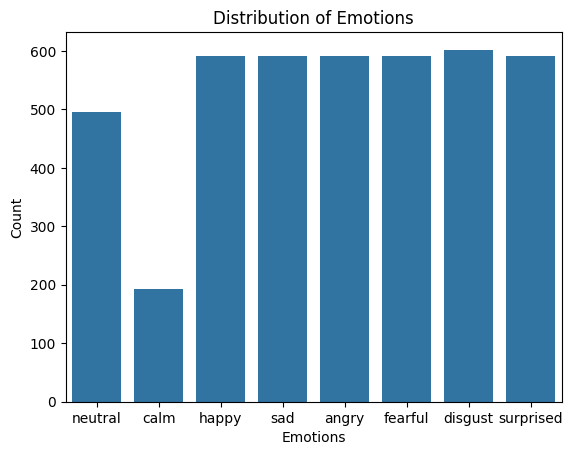

label
6    602
5    592
3    592
7    592
2    592
4    592
0    496
1    192
Name: count, dtype: int64


In [5]:
emo = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

# Create a count plot
sns.countplot(data=Features, x='label')
plt.xticks(ticks=range(len(emo)), labels=emo)

# Show the plot
plt.xlabel("Emotions")
plt.ylabel("Count")
plt.title("Distribution of Emotions")
plt.show()

print(Features['label'].value_counts())

In [6]:
X = Features.drop('label', axis = 1)
Y = Features['label']

In [7]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.3, random_state = 42, stratify = Y)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.5, random_state = 42, stratify = y_tosplit)

### Preprocess The data

In [8]:
def extract_features(data, sample_rate):
    result = np.array([])

    # Ensure n_fft is never larger than the audio signal length
    n_fft = min(512, len(data))
    hop_length = n_fft // 2

    # Zero-Crossing Rate (ZCR)
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data, hop_length=hop_length).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data, n_fft=n_fft, hop_length=hop_length))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate, n_fft=n_fft, hop_length=hop_length).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate, n_fft=n_fft, hop_length=hop_length).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value (RMS)
    rms = np.mean(librosa.feature.rms(y=data, hop_length=hop_length).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate, n_fft=n_fft, hop_length=hop_length).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    # Spectral Contrast
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate, n_fft=n_fft, hop_length=hop_length).T, axis=0)
    result = np.hstack((result, spectral_contrast))  # stacking horizontally

    # Spectral Rolloff
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate, n_fft=n_fft, hop_length=hop_length).T, axis=0)
    result = np.hstack((result, spectral_rolloff))  # stacking horizontally

    # Spectral Bandwidth
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate, n_fft=n_fft, hop_length=hop_length).T, axis=0)
    result = np.hstack((result, spectral_bandwidth))  # stacking horizontally

    # Tonnetz (Tonal Centroids)
    harmonic = librosa.effects.harmonic(y=data, n_fft=n_fft, hop_length=hop_length)
    tonnetz = np.mean(librosa.feature.tonnetz(y=harmonic, hop_length=hop_length, sr=sample_rate).T, axis=0)
    result = np.hstack((result, tonnetz))  # stacking horizontally

    return result

In [9]:
def processData(data, sample_rate):
    # data, sample_rate = librosa.load(path)
    data = nr.reduce_noise(y=data, sr=sample_rate)
    data = librosa.util.normalize(data)
    data, index = librosa.effects.trim(data, top_db=20)
    
    features = extract_features(data, sample_rate)
    return features

### Agument The Trainig Data

In [10]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    rate = np.random.uniform(0.8, 1.2)  # Random stretch rate between 0.8 and 1.2
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sample_rate):
    pitch_factor = np.random.uniform(-1, 1)  # Random pitch factor between -1 and 1
    return librosa.effects.pitch_shift(data, sr=sample_rate, n_steps=pitch_factor)

In [11]:
def AgumentData(data, sample_rate):
    
    # without augmentation
    res1 = processData(data, sample_rate)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = processData(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = processData(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [12]:
processed_x_train = []
y_train = []

for file in x_train['paths']:
    data, sample_rate  = librosa.load(file)
    audio = AgumentData(data, sample_rate)
    # processed_x_train.append(audio.to_list)
    
    if (find_emotion_T(file) != "-1"): #TESS Data
        name = find_emotion_T(file)
    else:                              #RAVDESS Data
        name = file[6:8]
        
    for i in audio:
        processed_x_train.append(i)
        y_train.append(emotionfix(name)) 
y_train_class = tf.keras.utils.to_categorical(y_train, 8)
y_train_class = y_train_class.astype(np.int8)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=568
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=568
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=560
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=664
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=656
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=608
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: 

In [22]:
processed_x_train_dataset = pd.DataFrame(processed_x_train)
y_train_class_dataset = pd.DataFrame(y_train_class)


#saving dataset
processed_x_train_dataset.to_csv('/workspace/After Agument/processed_x_train_dataset.csv', index =False)
y_train_class_dataset.to_csv('/workspace/After Agument/y_train_class_dataset.csv', index =False)

print(processed_x_train_dataset.shape)
print(y_train_class_dataset.shape)

(8925, 177)
(8925, 8)


In [25]:
processed_x_val = []
y_val = []

for file in x_val['paths']:
    data, sample_rate  = librosa.load(file)
    processed_x_val.append(processData(data, sample_rate))
    
    if (find_emotion_T(file) != "-1"): #TESS Data
        name = find_emotion_T(file)
    else:                              #RAVDESS Data
        name = file[6:8]
    
    y_val.append(emotionfix(name)) 
    
y_val_class = tf.keras.utils.to_categorical(y_val, 8)
y_val_class = y_val_class.astype(np.int8)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=624
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=552
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=704
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=864
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=432
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=880
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: 

In [26]:
processed_x_val = pd.DataFrame(processed_x_val)
y_val_class = pd.DataFrame(y_val_class)


#saving dataset
processed_x_val.to_csv('/workspace/After Agument/processed_x_val.csv', index =False)
y_val_class.to_csv('/workspace/After Agument/y_val_class.csv', index =False)

print(processed_x_val.shape)
print(y_val_class.shape)

(637, 177)
(637, 8)


In [147]:
processed_x_test = []
y_test = []

for file in x_test['paths']:
    data, sample_rate  = librosa.load(file)
    processed_x_test.append(processData(data, sample_rate))
    
    if (find_emotion_T(file) != "-1"): #TESS Data
        name = find_emotion_T(file)
    else:                              #RAVDESS Data
        name = file[6:8]
    
    y_test.append(emotionfix(name))
y_test_class = tf.keras.utils.to_categorical(y_test, 8)
y_test_class = y_test_class.astype(np.int8)

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=554
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=632
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=840
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=520
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=600
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=560
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: 

In [149]:
processed_x_test = pd.DataFrame(processed_x_test)
y_test_class = pd.DataFrame(y_test_class)


#saving dataset
processed_x_test.to_csv('/workspace/After Agument/processed_x_test.csv', index =False)
y_test_class.to_csv('/workspace/After Agument/y_test_class.csv', index =False)

print(processed_x_test.shape)
print(y_test_class.shape)

(638, 177)
(638, 8)


### Procces the data

In [41]:
from sklearn.preprocessing import StandardScaler

In [42]:
scaler = StandardScaler()

# Fit the scaler on the training data and transform the training data
processed_x_train = scaler.fit_transform(processed_x_train)

# Use the fitted scaler to transform the validation and test data
processed_x_val = scaler.transform(processed_x_val)
processed_x_test = scaler.transform(processed_x_test)

In [43]:
processed_x_train = np.expand_dims(processed_x_train, axis=1)
processed_x_val = np.expand_dims(processed_x_val, axis=1)
processed_x_test = np.expand_dims(processed_x_test, axis=1)

In [139]:
# x_train, x_val, and x_test shape check.
print(np.shape(processed_x_train))
print(np.shape(processed_x_val))
print(np.shape(processed_x_test))

(8925, 1, 177)
(637, 1, 177)
(638, 1, 177)


In [143]:
Train_dataset = tf.data.Dataset.from_tensor_slices((processed_x_train, y_train_class))
Train_dataset = Train_dataset.batch(32, drop_remainder=True)

Val_dataset = tf.data.Dataset.from_tensor_slices((processed_x_val, y_val_class))
Val_dataset = Val_dataset.batch(np.shape(processed_x_val)[0])

Test_dataset = tf.data.Dataset.from_tensor_slices((processed_x_test, y_test_class))
Test_dataset = Test_dataset.batch(np.shape(processed_x_test)[0])

In [46]:
from tensorflow.keras.layers import Masking

In [49]:
# Initializing the model
l2_lambda = 0.001
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(1,177)))
model.add(layers.LSTM(128, return_sequences=True, kernel_regularizer=l2(l2_lambda) ))
# model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.LSTM(128,return_sequences=False, kernel_regularizer=l2(l2_lambda)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(32))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

checkpoint_path = 'model_best.keras'

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_loss',
                           mode='low')

model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
                metrics=['categorical_accuracy'])

history = model.fit(Train_dataset, epochs=50,
                      validation_data = Val_dataset,
                        callbacks = mcp_save
                      )
model.load_weights(checkpoint_path)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 1, 177)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 128)         │       156,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 293,288 (1.12 MB)

 Trainable params: 292,968 (1.12 MB)

 Non-trainable params: 320 (1.25 KB)

None
Epoch 1/50


/tmp/ipykernel_2011/1302171997.py:26: UserWarning: ModelCheckpoint mode 'low' is unknown, fallback to auto mode.
  mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,


278/278 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - categorical_accuracy: 0.6672 - loss: 1.4120 - val_categorical_accuracy: 0.9639 - val_loss: 1.1677
Epoch 2/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.9217 - loss: 0.5255 - val_categorical_accuracy: 0.9859 - val_loss: 0.3143
Epoch 3/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - categorical_accuracy: 0.9530 - loss: 0.3700 - val_categorical_accuracy: 0.9890 - val_loss: 0.2236
Epoch 4/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.9639 - loss: 0.3183 - val_categorical_accuracy: 0.9859 - val_loss: 0.2086
Epoch 5/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.9708 - loss: 0.2573 - val_categorical_accuracy: 0.9843 - val_loss: 0.1961
Epoch 6/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.9734 - loss: 0.2416 - val_categorical_accuracy: 0.9859 - val_loss: 0.1749
Epoch 7/50
278/278 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - categorical_accuracy: 0.9774 - loss: 0.2171 -

## Train Fit Visualization

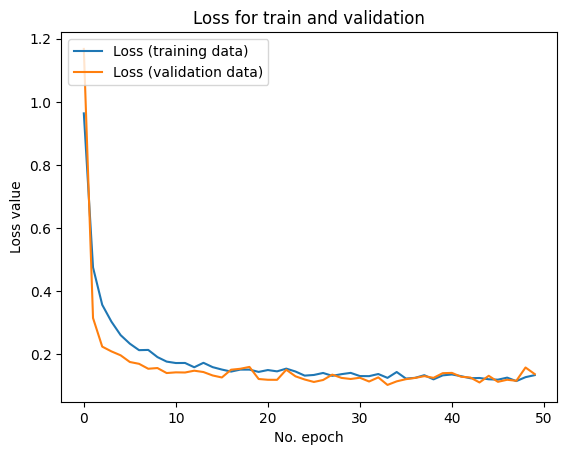

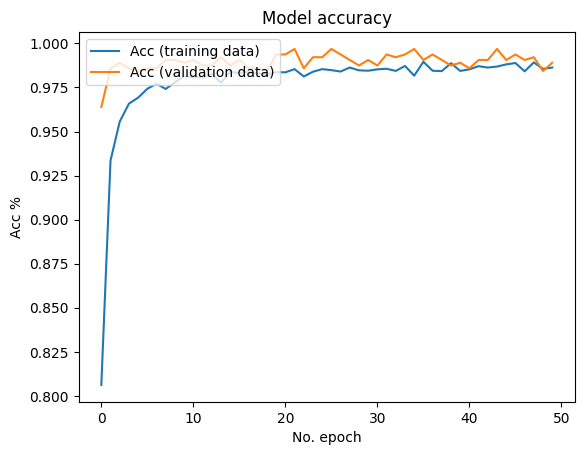

In [50]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Validation Score

In [51]:
# Validation score
loss,acc = model.evaluate(Val_dataset, verbose=2)

1/1 - 0s - 18ms/step - categorical_accuracy: 0.9937 - loss: 0.1022


In [53]:
emo = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

In [87]:
next(iter(Val_dataset))[1] == next(iter(Test_dataset))[1]

<tf.Tensor: shape=(637, 8), dtype=bool, numpy=
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])>

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Text(0.5, 58.7222222222222, 'Predicted emotion')

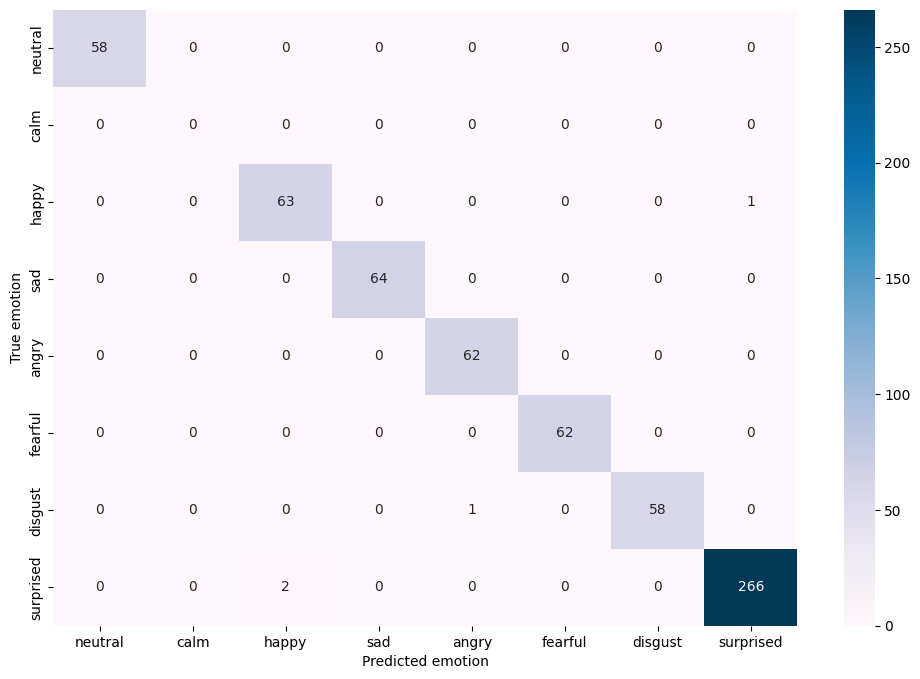

In [66]:
# Validation Confusion matrix

yLabel = np.argmax(next(iter(Val_dataset))[1], axis = 1)
predictions = model.predict(next(iter(Val_dataset))[0])
predLabel = np.argmax(predictions, axis=1)

cm=confusion_matrix(yLabel, predLabel, labels=np.arange(len(emo)))


cm_df = pd.DataFrame(cm,emo,emo)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [67]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(emo[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 1.0000
calm : nan
happy : 0.9844
sad : 1.0000
angry : 1.0000
fearful : 1.0000
disgust : 0.9831
surprised : 0.9925


/tmp/ipykernel_2011/189458094.py:5: RuntimeWarning: invalid value encountered in divide
  acc = values / row_sum


In [71]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model

model_json = model.to_json()
saved_model_path = '/workspace/After Agument/model 99.json'
saved_weights_path = '/workspace/After Agument/model 99.weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)

model.save_weights(saved_weights_path)
print("Saved model to disk")


Saved model to disk


In [ ]:
# Reading the model from JSON file

saved_model_path = '/workspace/Test/model81.json'
saved_weights_path = '/workspace/Test/model81_weights.h5'

with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()

# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
                metrics=['categorical_accuracy'])

# Model's structure visualization
# tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

## Test Set Evaluation

In [145]:
loss, acc = model.evaluate(Test_dataset, verbose=2) 

1/1 - 0s - 17ms/step - categorical_accuracy: 0.9906 - loss: 0.1089


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Text(0.5, 58.7222222222222, 'Predicted emotion')

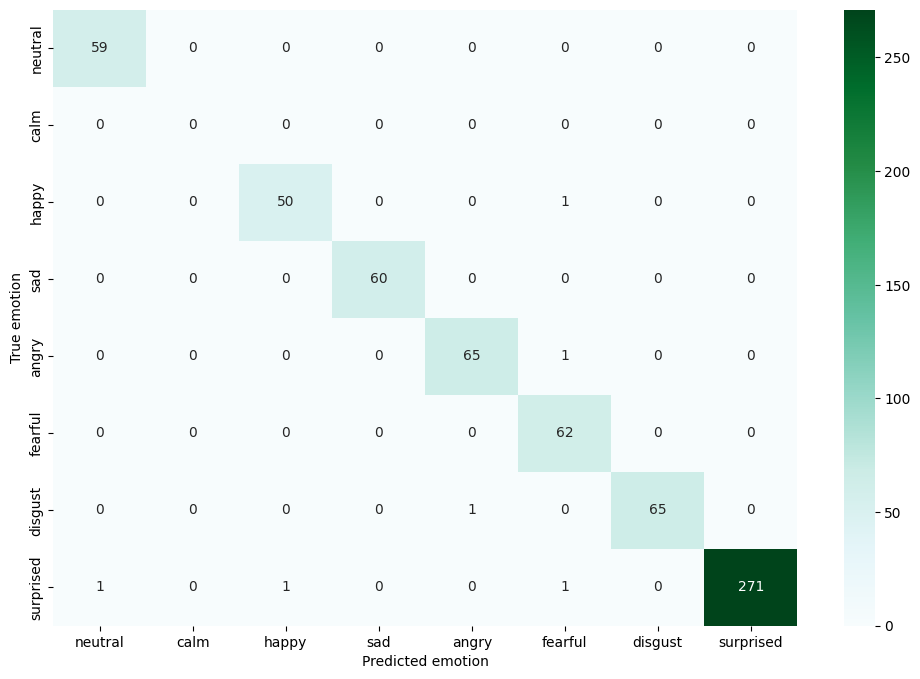

In [146]:
# Test set Confusion matrix

yLabel = np.argmax(next(iter(Test_dataset))[1], axis = 1)
yHat = model.predict(next(iter(Test_dataset))[0])
predLabel = np.argmax(yHat, axis=1)

cm=confusion_matrix(yLabel, predLabel, labels=np.arange(len(emo)))


cm_df = pd.DataFrame(cm,emo,emo)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [70]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(emo[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 1.0000
calm : nan
happy : 0.9844
sad : 1.0000
angry : 1.0000
fearful : 1.0000
disgust : 0.9831
surprised : 0.9925


/tmp/ipykernel_2011/3495934980.py:5: RuntimeWarning: invalid value encountered in divide
  acc = values / row_sum


In [73]:
import joblib

In [74]:
joblib.dump(scaler, '/workspace/After Agument/scaler99.pkl')

['/workspace/After Agument/scaler99.pkl']

In [151]:
scaler = joblib.load('/workspace/Before Agument/scaler79.pkl')